# Multithreaded Binomail Tree

Simulate these models
```
S = 100; K = 100; r = 0.03; v = 0.3, T = 1; N = 1000
S = 110; K= 100; r = 0.03, v= 0.3; T = 1;  N = 1500
S = 90;   K = 100; r = 0j.03; v = 0.3; T = 1;  N = 100
```

In [178]:
import numpy as np
from scipy import stats
import pandas as pd
import timeit
import math

In [151]:
import numpy as np
from scipy import stats

def BS(S, K, t, r, sigma):
    assert S>=0 and K>=0 and sigma>=0 and t>=0 and r >=0, "All inputs should be non-negative"
    assert S > 0 and K > 0, "Inputs \'S\' (stock price) and \'K\' (strike) should be positive."
    d_1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    
    return stats.norm.cdf(d_1, 0, 1)*S - stats.norm.cdf(d_2, 0, 1)*K*np.exp(-r*t)

## 1. Black Scholes Reference Price

In [363]:
def N_CDF(x):
    '''CDF of Standard Normal Distribution'''
    return stats.norm.cdf(x, 0, 1)

def BS(S, K, t, r, sigma):
    assert S>=0 and K>=0 and sigma>=0 and t>=0 and r >=0, "All inputs should be nonnegative"
    assert S > 0 and K > 0, "Inputs \'S\' and \'K\' should be positive."
    d_1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    
    return N_CDF(d_1)*S - N_CDF(d_2)*K*np.exp(-r*t)

## 2. Naïve Binomial Tree Pricer

Stock price dynamics:
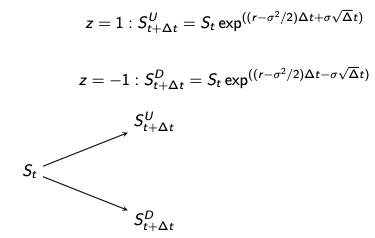

Global stock price tree:
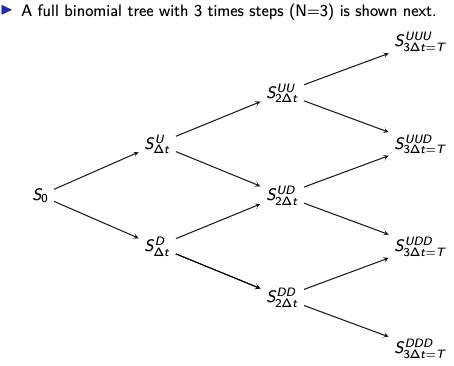

Option price:
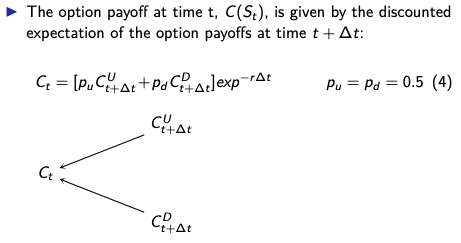

In [571]:
def treePricer_1(S, K, t, r, v, N):
    '''Improvement: vectorized forward, iterative backward propagation'''
    # up/down parameters
    delta_t = 1.*t / N
    u = np.exp((r - 0.5*v**2)*delta_t + v*np.sqrt(delta_t))
    d = np.exp((r - 0.5*v**2)*delta_t - v*np.sqrt(delta_t))

    # Terminal stock
    ST = np.array([S0*(u**i)*(d**(N-i)) for i in range(N+1)])

    # Terminal Call Option Value (Payoff)
    CT = np.where(ST>K, ST - K, 0)

    # loop backward
    for j in range(N):
        for i in range(N):
            CT[i] = np.exp(-r*delta_t)*0.5*(CT[i] + CT[i+1])
    return CT[0]

def treePricer_2(S, K, t, r, v, N):
    '''Improvement: vectorized forward, iterative backward propagation'''
    # up/down parameters
    delta_t = 1.*t / N
    u = np.exp((r - 0.5*v**2)*delta_t + v*np.sqrt(delta_t))
    d = np.exp((r - 0.5*v**2)*delta_t - v*np.sqrt(delta_t))


    # Terminal stock
    ST = np.array([S0*(u**i)*(d**(N-i)) for i in range(N+1)])

    # Terminal Call Option Value (Payoff)
    CT = np.where(ST>K, ST - K, 0)

    # loop backward
    for j in range(N):
        for i in range(N):
            CT[i] = np.exp(-r*delta_t)*0.5*(CT[i] + CT[i+1])
    return CT[0]

def treePricer_3(S, K, t, r, v, N):
    '''Improvement: vectorized forward & backward'''
    # up/down parameters
    delta_t = 1.*t / N
    u = np.exp((r - 0.5*v**2)*delta_t + v*np.sqrt(delta_t))
    d = np.exp((r - 0.5*v**2)*delta_t - v*np.sqrt(delta_t))
    pTol = 0.5**N
    
    # Terminal stock
    CT   = np.array([max((S*(u**i)*(d**(N-i)) - K)*(math.comb(N,i)*pTol), 0) for i in range(N+1)])

    # loop backward 
    return np.exp(-r*t)*np.sum(CT)


def treePricer_4(S, K, t, r, v, N):
    '''Improvement: vectorized forward & backward'''
    # up/down parameters
    delta_t = 1.*t / N
    u = np.exp((r - 0.5*v**2)*delta_t + v*np.sqrt(delta_t))
    d = np.exp((r - 0.5*v**2)*delta_t - v*np.sqrt(delta_t))
    pTol = 0.5**N
    
    # Terminal stock
    CT = np.array([(S*(u**i)*(d**(N-i)) - K) * math.comb(N,i)  for i in range(N+1)])
    CT = np.where(CT >= 0, CT, 0.0)
    
    # loop backward 
    return pTol*np.exp(-r*t)*np.sum(CT) 

In [562]:
%%cython -a
cimport cython
from libc.math cimport sqrt, exp

cdef double treePricer_5(double S, double K, double t, double r, double sigma, int N):
    '''Improvement: vectorized forward & backward'''
    # up/down parameters
    cdef double delta_t = t / 1.0*N;
    cdef double u = exp((r - 0.5*sigma*sigma)*delta_t + sigma*sqrt(delta_t));
    cdef double pTol = 0.5**N;
    cdef double d_u = exp((r - 0.5*sigma*sigma)*delta_t - sigma*sqrt(delta_t)) * u**(-1);
    
    # Terminal stock
    cdef double C0 = 0.0;
    cdef double prod = pTol;
    cdef double N_loc = N;
    
    S*= u**N;
    if (S - K <= 0.0):
        return C0;
    
    cdef int i = 0
    for i in range(N-1, -1, -1):
        C0 += (S-K)*prod
        prod *= 1.0*(i+1) * (N-i)**(-1)
        S *= d_u
    
    # loop backward 
    return C0*exp(-r*t)

In [583]:
import numba
import random

@jit("float32(float32,float32,float32,float32,float32,intp)", nopython=False,fastmath=True)
def treePricer_6(S, K, t, r, v, N):
    delta_t = 1.*t / N
    u = np.exp((r - 0.5*v**2)*delta_t + v*np.sqrt(delta_t))
    d = np.exp((r - 0.5*v**2)*delta_t - v*np.sqrt(delta_t))
    pTol = 0.5**N
    
    # Terminal stock
    CT = np.array([(S*(u**i)*(d**(N-i)) - K) * math.comb(N,i)  for i in range(N+1)])
    CT = np.where(CT >= 0, CT, 0.0)
    
    # loop backward 
    return pTol*np.exp(-r*t)*np.sum(CT) 

/var/folders/r2/qhw24dkn7zd0pk46l7kps5jm0000gn/T/ipykernel_7414/406133180.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "treePricer_6" failed type inference due to: Unknown attribute 'comb' of type Module(<module 'math' from '/Users/carlo/miniconda3/envs/deep/lib/python3.9/lib-dynload/math.cpython-39-darwin.so'>)

File "../../../var/folders/r2/qhw24dkn7zd0pk46l7kps5jm0000gn/T/ipykernel_7414/406133180.py", line 12:
<source missing, REPL/exec in use?>

During: typing of get attribute at /var/folders/r2/qhw24dkn7zd0pk46l7kps5jm0000gn/T/ipykernel_7414/406133180.py (12)

File "../../../var/folders/r2/qhw24dkn7zd0pk46l7kps5jm0000gn/T/ipykernel_7414/406133180.py", line 12:
<source missing, REPL/exec in use?>

  @jit("float32(float32,float32,float32,float32,float32,intp)", nopython=False,fastmath=True)
/Users/carlo/miniconda3/envs/deep/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "treePricer

In [584]:
treePricer_6(S0, K, t, r, v, N)

17.765234474539593

In [585]:
# Check for Correctness
# Input Parameters
N = 1000

S0 = 55
K  = 50
r  = 0.03
v  = 0.25
t  = 5

print('BS price:    ', round(BS(S0, K, t, r, v), 2))

print('tree 1:      ', round(treePricer_1(S0, K, t, r, v, N), 2))
print('tree 2:      ', round(treePricer_2(S0, K, t, r, v, N), 2))
print('tree 3:      ', round(treePricer_3(S0, K, t, r, v, N), 2))
print('tree 4:      ', round(treePricer_4(S0, K, t, r, v, N), 2))
#print('tree 5:      ', round(treePricer_5(S0, K, t, r, v, N), 2))
#print('tree 6:      ', round(treePricer_6(S0, K, t, r, v, N), 2))

BS price:     17.76
tree 1:       17.77
tree 2:       17.77
tree 3:       17.77
tree 4:       17.77


In [586]:
%timeit treePricer_1(S0, K, t, r, v, N)

1.47 s ± 82.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [587]:
%timeit treePricer_2(S0, K, t, r, v, N)

1.5 s ± 66.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [588]:
%timeit treePricer_3(S0, K, t, r, v, N)

96.3 ms ± 5.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [589]:
%timeit treePricer_4(S0, K, t, r, v, N)

106 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [590]:
%timeit treePricer_6(S0, K, t, r, v, N)

99.3 ms ± 5.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [570]:
import cython
if cython.compiled:
    print("Yep, I'm compiled.")
else:
    print("Just a lowly interpreted script.")

Just a lowly interpreted script.
